In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import DebertaTokenizer, DebertaModel

C:\Users\Dancouga\anaconda3\envs\SINA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the data from Excel file
file_path = "student_questions_for_labeling (Final).xlsx"
df = pd.read_excel(file_path)

In [4]:
# Prepare the data (questions and labels)
questions = df['Question'].tolist()
labels = df['Label'].tolist()

In [5]:
# Check the count of each label in the loaded dataset
label_counts = Counter(labels)
print("Label counts in the original dataset:", label_counts)

Label counts in the original dataset: Counter({1: 196, 2: 193, 3: 192})


In [6]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Calculate class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(encoded_labels), 
    y=encoded_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [7]:
# Split the data into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(questions, encoded_labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [8]:
# Define the tokenizer (using DeBERTa)
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

In [9]:
# Create a Dataset class
class QuestionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# DataLoader for training, validation, and testing
MAX_LEN = 128
BATCH_SIZE = 8

train_dataset = QuestionDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = QuestionDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = QuestionDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
# Define the DeBERTa-based model
class QuestionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(QuestionClassifier, self).__init__()
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.deberta.config.hidden_size, n_classes)

        for param in self.deberta.parameters():
            param.requires_grad = False
        for param in self.deberta.encoder.layer[-3:].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Use the first token's hidden state as a pooled output
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
        output = self.drop(pooled_output)
        return self.out(output)

In [11]:
# Set up the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuestionClassifier(n_classes=len(label_encoder.classes_)).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training and evaluation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    correct_predictions = 0
    losses = 0
    
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        
        correct_predictions += torch.sum(preds == labels)
        losses += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return correct_predictions.double() / len(data_loader.dataset), losses / len(data_loader)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    correct_predictions = 0
    losses = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, dim=1)
            
            correct_predictions += torch.sum(preds == labels)
            losses += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return correct_predictions.double() / len(data_loader.dataset), losses / len(data_loader), all_labels, all_preds

In [12]:
# Training loop with validation
epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


early_stop_count = 0
patience = 20

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss, _, _ = eval_model(model, val_loader, loss_fn, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping
    if len(val_losses) > 1 and val_loss > min(val_losses):
        early_stop_count += 1
    else:
        early_stop_count = 0

    if early_stop_count >= patience:
        print("Early stopping triggered")
        break

Epoch 1/100
Train Loss: 1.0895, Train Accuracy: 0.3719
Val Loss: 1.0011, Val Accuracy: 0.5402
Epoch 2/100
Train Loss: 0.7583, Train Accuracy: 0.6453
Val Loss: 0.7474, Val Accuracy: 0.6552
Epoch 3/100
Train Loss: 0.6093, Train Accuracy: 0.7118
Val Loss: 0.7019, Val Accuracy: 0.6552
Epoch 4/100
Train Loss: 0.4774, Train Accuracy: 0.8054
Val Loss: 0.6885, Val Accuracy: 0.7011
Epoch 5/100
Train Loss: 0.3587, Train Accuracy: 0.8498
Val Loss: 0.7021, Val Accuracy: 0.6897
Epoch 6/100
Train Loss: 0.2748, Train Accuracy: 0.8744
Val Loss: 0.7581, Val Accuracy: 0.7241
Epoch 7/100
Train Loss: 0.2313, Train Accuracy: 0.9138
Val Loss: 0.7105, Val Accuracy: 0.7356
Epoch 8/100
Train Loss: 0.1712, Train Accuracy: 0.9384
Val Loss: 0.8012, Val Accuracy: 0.7356
Epoch 9/100
Train Loss: 0.1223, Train Accuracy: 0.9581
Val Loss: 0.9053, Val Accuracy: 0.7126
Epoch 10/100
Train Loss: 0.0933, Train Accuracy: 0.9778
Val Loss: 0.8598, Val Accuracy: 0.7241
Epoch 00010: reducing learning rate of group 0 to 2.0000e-0

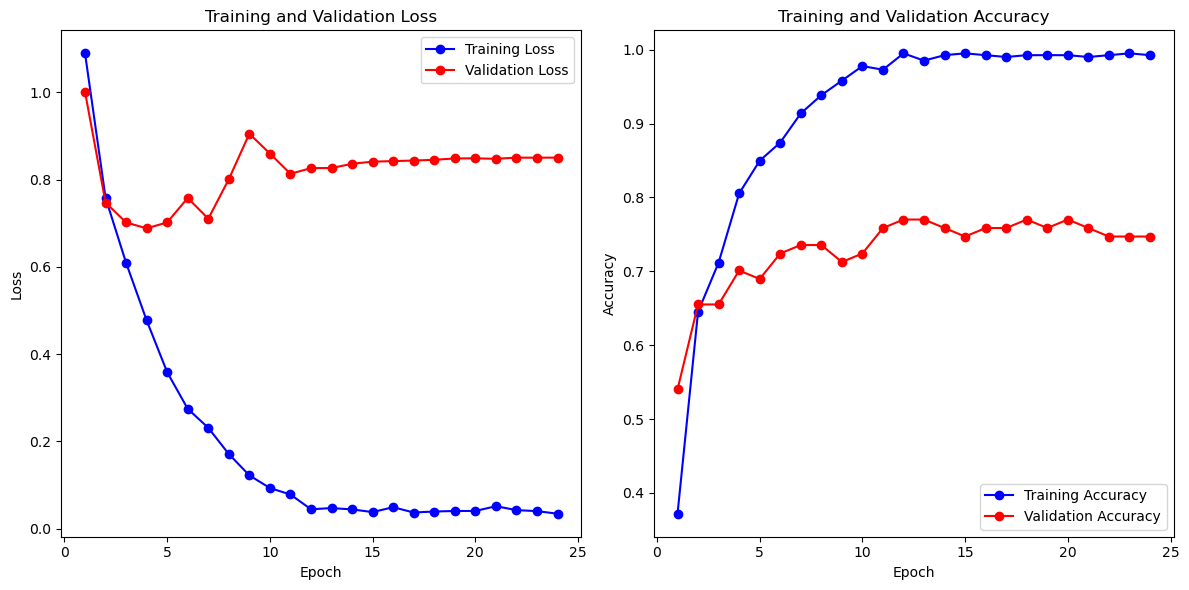

In [13]:
# Visualize training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', color='b', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', color='r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.3239, Test Accuracy: 0.8636


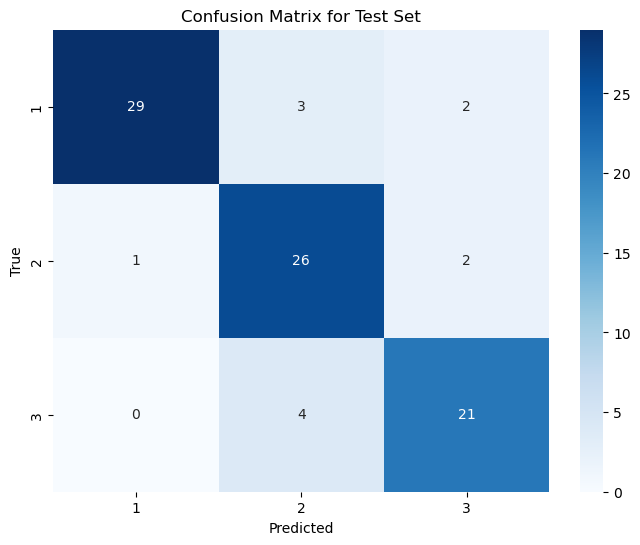

In [14]:
# Evaluate on the test set and calculate additional metrics
test_acc, test_loss, test_labels, test_preds = eval_model(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Confusion Matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [15]:
# Classification Report for detailed performance metrics
print("Classification Report:")
report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)

# Display Precision, Recall, and F1 Score for each class
for label, metrics in report.items():
    if label in label_encoder.classes_:
        print(f"\nLabel: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1 Score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")

# Display overall averages
print("\nOverall Performance:")
print(f"  Average Precision: {report['weighted avg']['precision']:.4f}")
print(f"  Average Recall: {report['weighted avg']['recall']:.4f}")
print(f"  Average F1 Score: {report['weighted avg']['f1-score']:.4f}")
print(f"  Accuracy: {report['accuracy']:.4f}")

Classification Report:

Label: 1
  Precision: 0.9667
  Recall: 0.8529
  F1 Score: 0.9062
  Support: 34.0

Label: 2
  Precision: 0.7879
  Recall: 0.8966
  F1 Score: 0.8387
  Support: 29.0

Label: 3
  Precision: 0.8400
  Recall: 0.8400
  F1 Score: 0.8400
  Support: 25.0

Overall Performance:
  Average Precision: 0.8718
  Average Recall: 0.8636
  Average F1 Score: 0.8652
  Accuracy: 0.8636


C:\Users\Dancouga\AppData\Local\Temp\ipykernel_38728\2033045417.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label in label_encoder.classes_:


In [16]:
# Function to predict the label of a new question
def predict_question(question, model, tokenizer, max_len, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        question,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)
    
    return label_encoder.inverse_transform([prediction.cpu().item()])[0]


In [17]:
# Import random for selecting random questions
import random

# Encode the labels of the augmented dataset
encoded_labels_augmented = label_encoder.transform(labels)

# Create a mapping of questions to their original labels
question_to_label = dict(zip(questions, encoded_labels))

# Select 10 random questions from the dataset for prediction
random_questions = random.sample(questions, 10)

# Predict the label for each randomly selected question and print the result
print("Predicted Labels for Random Questions:")
for i, question in enumerate(random_questions, start=1):
    predicted_label = predict_question(question, model, tokenizer, MAX_LEN, device)
    original_label = label_encoder.inverse_transform([question_to_label[question]])[0]
    
    # Check if the prediction is correct
    is_correct = "(Correct)" if predicted_label == original_label else "(Incorrect)"
    
    # Print the result
    print(f"{i}. Question: '{question}'")
    print(f"   Original Label: {original_label}, Predicted Label: {predicted_label} {is_correct}\n")

Predicted Labels for Random Questions:
1. Question: 'I think it would be good to combine items 3 and 4 since they fall under the same visualization category.'
   Original Label: 1, Predicted Label: 1 (Correct)

2. Question: 'Could we reinterpret the diagram to reflect motivational development stages for learners, where AI takes over the instructor's responsibilities?'
   Original Label: 3, Predicted Label: 3 (Correct)

3. Question: 'How can we leverage AI to reduce the workload for teachers while maintaining quality teaching outcomes?'
   Original Label: 3, Predicted Label: 2 (Incorrect)

4. Question: 'Could you explain predicting bounding boxes?'
   Original Label: 1, Predicted Label: 1 (Correct)

5. Question: 'How can I change the code to use an average?'
   Original Label: 1, Predicted Label: 1 (Correct)

6. Question: 'If I use a baseline model, what code should I use?'
   Original Label: 2, Predicted Label: 2 (Correct)

7. Question: 'How can I handle questions generated by students

In [18]:
# Create a new DataFrame with the original questions, original labels, predicted labels, and comparison
predictions_data = {
    'Question': questions,
    'Original Label': labels,
    'Predicted Label': [predict_question(q, model, tokenizer, MAX_LEN, device) for q in questions],
}

# Create a DataFrame from the data
predictions_df = pd.DataFrame(predictions_data)

# Add a column for match/mismatch between original and predicted labels
predictions_df['Match'] = predictions_df.apply(lambda row: 'Match' if row['Original Label'] == row['Predicted Label'] else 'Mismatch', axis=1)

# Save to a new Excel file
output_file_path = "predicted_labels_comparison (DeBERTa).xlsx"
predictions_df.to_excel(output_file_path, index=False)

print(f"Predicted labels and comparison saved to {output_file_path}")

Predicted labels and comparison saved to predicted_labels_comparison (DeBERTa).xlsx
